# Newsgroups Clustering

The 20 Newsgroups dataset, available in scikit-learn, is composed of roughly 20,000 newsgroup articles (more info here: http://qwone.com/~jason/20Newsgroups/). Today, you will be looking at some of these texts and doing the following: 
- Exploring the 20 newsgroups dataset
- Cleaning the texts to prepare them for analysis
    - removing useless punctutation/numbers
    - lemmatizing words
- Exploring clustering algorithms
    - KMeans
    - Hierarchical (agglomerative) clustering
- Going further
- Thinking about how you can use clustering analyses on other real-world texts
    - survey responses
    - twitter
    - etc.

Load in some useful modules

In [1]:
# general modules 
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import re
import string
import os
os.environ["OMP_NUM_THREADS"] = '5' # for K-Means

# scikit-learn modules 
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import homogeneity_score

# NLP modules
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/x-dchawra/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/x-dchawra/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/x-dchawra/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/x-dchawra/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# 1. Exploration of the 20 Newsgroups Dataset

In [2]:
# list of categories we'll explore
input_categories = [
 'comp.graphics',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 ]

In [3]:
# get the data, removing headers, footers and quotes 
newsgroups_data = fetch_20newsgroups(subset = 'train', categories = input_categories, remove = ("headers", "footers", "quotes"), shuffle = False)

# grab the data, and convert it to an array to make future indexing easier
newsgroups_data_orig = np.array(newsgroups_data.data)

# get the classification labels, and the set of main categories that each text belongs to
targets = newsgroups_data.target
target_names = newsgroups_data.target_names

In [4]:
# print the first 250 characters of the first 10 documents, and the class they belong to
for i in range(20):
    category_name = target_names[targets[i]]
    print("================================================================")
    print("Category: {} \n----------------------------------------------------------------".format(category_name))
    print(''.join([newsgroups_data_orig[i][:250].strip(), '...']))

Category: rec.sport.baseball 
----------------------------------------------------------------
morgan and guzman will have era's 1 run higher than last year, and
 the cubs will be idiots and not pitch harkey as much as hibbard.
 castillo won't be good (i think he's a stud pitcher)...
Category: comp.sys.mac.hardware 
----------------------------------------------------------------
Well, I just got my Centris 610 yesterday.  It took just over two 
weeks from placing the order.  The dealer (Rutgers computer store) 
appologized because Apple made a substitution on my order.  I ordered
the one without ethernet, but they substitute...
Category: comp.sys.mac.hardware 
----------------------------------------------------------------
To the best of my knowledge there aren't any problems with Quadras and
blind transfers.  Trouble with blind transfers usually means the programmer
screwed up the TIBs or didn't test their driver with the device in question.
Well designed TIBs poll or...
Category: c

Some interesting observations to note: 
- Some texts are much longer than others
    - Some contain no information at all!
- Some contain information in tables
- Some contain email addresses

As noted above, there's a lot of variability to these texts. In addition to the varying length, content, etc. there's a lot of issues that can arise when analyzing this data. For example, punctuation, typos, whitespaces, numbers, etc. To handle some of these, we'll do the following:
- remove punctuation
- remove single letters 
- remove extra whitespace

In [5]:
def remove_punctuation(text):
    text = re.sub(r'''      # Start raw string block
               \W+       # Accept one or more non-word characters
               \s*       # plus zero or more whitespace characters,
               ''',      # Close string block
               ' ',      # and replace it with a single space
               text,
               flags=re.VERBOSE)
    return text

In [6]:
def remove_single_letters(text):
    """
    

    Parameters
    ----------
    text : str
        a document

    Returns
    -------
    text : str
        a string with single letter characters removed.

    """
    text = re.sub(r'\b[a-zA-Z]\b', '', text)
    return text

In [7]:
def remove_numbers(text):
    """
    

    Parameters
    ----------
    text : str
        a document.

    Returns
    -------
    text : str
        a document with numbers removed.

    """
    text = re.sub(r'[0-9]+', '', text)
    return text

In [8]:
def clean_text(text):
    """
    

    Parameters
    ----------
    text : str
        a document.

    Returns
    -------
    text : str
        a document with the following removed:
            - numbers
            - punctuation
            - single letter characters
            - underscores (for email signatures and handmade emojis) removed
            - removed additional whitespace

    """
    text = text.lower()
    
    # remove numbers
    text = remove_numbers(text)
    
    # remove punctuation
    text = remove_punctuation(text)
    
    # remove single letter characters 
    text = remove_single_letters(text)
    
    # remove underscores
    text = text.replace('_', "")
    
    # remove excessive whitespace from whatevers left
    text = " ".join(text.split())
    
    return text

In addition to cleaning the text, we'll need to stemmatize the remaining words

In [9]:
# grab list of stop words from nltk (includes contractions)
stop = stopwords.words('english')

# update the list 
stop += ["i'll", "i'm", 'i']

In [10]:
def tokenize(text):
    text = text.lower()
    text = " ".join([word for word in text.split() if word not in stop])
    tokens = nltk.word_tokenize(text)
    lemmatized_tokens = []
    for item in tokens:
        lemmatized_tokens.append(WordNetLemmatizer().lemmatize(item))
    # only want stems with length greater than 2
    lemmatized_tokens = [l for l in lemmatized_tokens if len(l) > 2]
    return lemmatized_tokens

In [11]:
# clean the data with the text cleaner
newsgroups_data_cleaned = np.array([clean_text(text) for text in newsgroups_data_orig])

In [12]:
# look at some of the cleaned texts before lemmatization
for i in range(10):
    category_name = target_names[targets[i]]
    print("================================================================")
    print("Category: {} \n----------------------------------------------------------------".format(category_name))
    print("".join([newsgroups_data_cleaned[i][:250], '...']))

Category: rec.sport.baseball 
----------------------------------------------------------------
morgan and guzman will have era run higher than last year and the cubs will be idiots and not pitch harkey as much as hibbard castillo won be good think he stud pitcher...
Category: comp.sys.mac.hardware 
----------------------------------------------------------------
well just got my centris yesterday it took just over two weeks from placing the order the dealer rutgers computer store appologized because apple made substitution on my order ordered the one without ethernet but they substituted one with ethernet he...
Category: comp.sys.mac.hardware 
----------------------------------------------------------------
to the best of my knowledge there aren any problems with quadras and blind transfers trouble with blind transfers usually means the programmer screwed up the tibs or didn test their driver with the device in question well designed tibs poll or loop a...
Category: comp.sys.mac.hardwa

In [13]:
# apply the tokenizer, and join the results
newsgroups_data_cleaned = np.array([" ".join(tokenize(text)) for text in newsgroups_data_cleaned])

In [14]:
# look at some of the cleaned texts after lemmatization
for i in range(10):
    category_name = target_names[targets[i]]
    print("================================================================")
    print("Category: {} \n----------------------------------------------------------------".format(category_name))
    print("".join([newsgroups_data_cleaned[i][:250], '...']))

Category: rec.sport.baseball 
----------------------------------------------------------------
morgan guzman era run higher last year cub idiot pitch harkey much hibbard castillo good think stud pitcher...
Category: comp.sys.mac.hardware 
----------------------------------------------------------------
well got centris yesterday took two week placing order dealer rutgers computer store appologized apple made substitution order ordered one without ethernet substituted one ethernet wanted know would alright must backlogged centri ethernet shipping an...
Category: comp.sys.mac.hardware 
----------------------------------------------------------------
best knowledge problem quadras blind transfer trouble blind transfer usually mean programmer screwed tib test driver device question well designed tib poll loop every point delay µsec occur usually occurs first byte block transfer device hiccup middl...
Category: comp.sys.mac.hardware 
---------------------------------------------------------

Notice how each category of texts has a specific category, to which each belongs to a broad category: 
- Computers ---> Systems ---> IBM ---> PC ---> Hardware
    - Computers
- Recreation ---> Sports ---> Hockey
    - Recreation

Let's get the specific categories, then the broad categories. 

Before doing this however, let's remove some of the texts as they contain very little information

In [15]:
# some texts are blank or have very little text, remove all texts with less than 20 characters or 5 tokens before continuing
good_texts = np.array([len(x) - x.count(' ') >= 100 and len(x.split()) >= 5 for x in newsgroups_data_cleaned])

In [16]:
# get the specific category labels (e.g. 'comp.sys.ibm.pc.hardware', 'rec.autos')
category_labels = np.array([target_names[x] for x in targets])

In [17]:
# make a list of broader category labels (e.g. recreation (rec), computers (comp), etc.) by splitting on first period
broad_category_labels = np.array([x.split('.')[0] for x in category_labels])

In [18]:
# remove bad texts from all labels
newsgroups_data_cleaned = newsgroups_data_cleaned[good_texts]
newsgroups_data_orig = newsgroups_data_orig[good_texts]
category_labels = category_labels[good_texts]
broad_category_labels = broad_category_labels[good_texts]

In [19]:
print("Specific Categories")
print("=====================================")
print(set(category_labels))

print("Broad Categories")
print("=====================================")
print(set(broad_category_labels))

Specific Categories
{'comp.sys.ibm.pc.hardware', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'comp.graphics', 'comp.sys.mac.hardware', 'comp.windows.x'}
Broad Categories
{'rec', 'comp'}


Apply the TfidfVectorizer to get a tf-idf representation of the cleaned text
- Ignore terms with a document frequency of more than 80% of documents
- Ignore terms with a document frequency of less than 5 documents
- Only look for single words (unigrams)

In [20]:
vectorizer = TfidfVectorizer(max_df = 0.80, min_df = 5, ngram_range = (1, 1))
count_vectorizer = CountVectorizer(max_df = 0.80, min_df = 5, ngram_range = (1, 1))
vectors = vectorizer.fit_transform(newsgroups_data_cleaned)

counts = count_vectorizer.fit_transform(newsgroups_data_cleaned)


In [29]:
from operator import le


terms = count_vectorizer.get_feature_names()
print(len(terms))
term_counts = counts.sum(axis=0).tolist()
print(len(term_counts[0]))
term_counts = sorted(zip(terms, term_counts[0]), key=lambda x: x[1])
term_counts.reverse()
num_terms = counts.shape[0]

print(f"Number of Unique Tokens: {num_terms}")
print("Most Common Terms:")
print("-" * len("Most Common Terms:"))
for i, j in term_counts[:10]:
    print(f"{i} - {j}")
print()
print("#"*20)
print()

least_common = term_counts[-10:]
least_common.reverse()

print("Least Common Terms:")
print("-" * len("Least Common Terms:"))
for i, j in least_common:
    print(f"{i} - {j}")

5773
5773
Number of Unique Tokens: 3139
Most Common Terms:
------------------
one - 1742
would - 1486
get - 1419
file - 1374
like - 1248
use - 1136
edu - 1098
game - 1074
window - 1064
drive - 1048

####################

Least Common Terms:
-------------------
accidentally - 5
acknowledge - 5
acquisition - 5
adapt - 5
admin - 5
admitted - 5
advise - 5
afterwards - 5
albeit - 5
alive - 5


In [22]:
tfidf_df = pd.DataFrame(vectors.todense(), columns = vectorizer.get_feature_names())
print(tfidf_df)

      aaa  abc  ability  able  absent  absolute  absolutely  abstract  absurd  \
0     0.0  0.0      0.0   0.0     0.0       0.0         0.0       0.0     0.0   
1     0.0  0.0      0.0   0.0     0.0       0.0         0.0       0.0     0.0   
2     0.0  0.0      0.0   0.0     0.0       0.0         0.0       0.0     0.0   
3     0.0  0.0      0.0   0.0     0.0       0.0         0.0       0.0     0.0   
4     0.0  0.0      0.0   0.0     0.0       0.0         0.0       0.0     0.0   
...   ...  ...      ...   ...     ...       ...         ...       ...     ...   
3134  0.0  0.0      0.0   0.0     0.0       0.0         0.0       0.0     0.0   
3135  0.0  0.0      0.0   0.0     0.0       0.0         0.0       0.0     0.0   
3136  0.0  0.0      0.0   0.0     0.0       0.0         0.0       0.0     0.0   
3137  0.0  0.0      0.0   0.0     0.0       0.0         0.0       0.0     0.0   
3138  0.0  0.0      0.0   0.0     0.0       0.0         0.0       0.0     0.0   

      abuse  accelerate  ac

# 2. Clustering

## KMeans 

KMeans is a clustering alogrithm that assumes quite a bit about the underlying structure of the data (e.g. is it spherical in nature), and only lets us use Euclidean distance, but there's a lot we can do with it. For more information on K-Means, see this link: https://en.wikipedia.org/wiki/K-means_clustering. For documentation on the KMeans package that we are using follow this link: [scikit-learn KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html?highlight=kmeans#sklearn.cluster.KMeans)

To start off, we'll cluster the data using a number of clusters equal to the number of broad categories and look at the results. A convenience function has been provided which will return a tabulation of two factors (cluster labels and true labels) and the homogenieity score (the degree to which observations in a cluster share the same true label). 

In [23]:
def get_cluster_results(cluster_labels, true_labels):
    # make a cross tab of the labels and broad categories
    cross_tab = pd.crosstab(true_labels, cluster_labels)
    
    # calculate homogenieity score
    h_score = homogeneity_score(true_labels, cluster_labels)
    return cross_tab, h_score

In [24]:
kmeans = KMeans(n_clusters = len(set(broad_category_labels)), random_state = 0)
kmeans.fit(vectors.toarray())
kmeans_labels = kmeans.labels_

In [25]:
cross_tab, h_score = get_cluster_results(kmeans_labels, broad_category_labels)
print(cross_tab)
print("======================")
print('Homogeneity Score: {:.2f}'.format(h_score))

col_0     0     1
row_0            
comp   1815    43
rec      64  1217
Homogeneity Score: 0.78


As you can see, most of the items in each cluster belong to a single broad category of texts. This score is quite good, can it be improved upon? A convenience function has been provided to print the documents for a single cluster. 

In [26]:
def print_cluster_documents(cluster_labels, cluster, documents, n_documents = 10, n_chars = 500, random_seed = 0, true_labels = None):
    np.random.seed(random_seed)
    random_idxs = np.random.choice(np.where(cluster_labels == cluster)[0], size = n_documents, replace = False)
    for i, idx in enumerate(random_idxs, 1):
        if true_labels is not None:
            print("Document {}, (true = {}):".format(i, true_labels[idx]))
        else:
            print("Document {}:".format(i))
        print("===========================================================")
        print("".join([documents[idx].strip()[:n_chars], '....']).strip(), '\n')

Print several documents for each cluster

In [27]:
for i, c in enumerate(np.unique(kmeans_labels)):
    print("Cluster {}".format(c))
    print_cluster_documents(kmeans_labels, c, newsgroups_data_cleaned, true_labels = broad_category_labels)
    if i != len(set(kmeans_labels)) - 1:
        print("\n---------------------------------------------------------------")

Cluster 0
Document 1, (true = comp):
sure give shot need get pin simms mean newer powerful mac system answer apple stated new mac use pin simms longer use pin simms.... 

Document 2, (true = comp):
question regarding sending null character across ethernet connection actual problem emacs unix editior need null character setting mark unfortunately know sent ibm across ethernet wondering anyboy know keyboard combination sending null character btw control shift ctrl work thanks.... 

Document 3, (true = comp):
dear netters noticed something rather weared think creating dialog shell widget running vue vuewm reason every time create dialog shell foreground backgroun color different compared toplevel shell anything special different body know anything problem fix without hardcodin color please respond kamlesh salzo cary usa.... 

Document 4, (true = comp):
printer model specification canon clc color laser copier ipu unit postscript intelligent processing unit hello recently purchased expensiv

### Results

So far, the clusters look fairly representative and homogeneous regarding the topics. Let's look at the contents of each cluster: 
- Cluster 0: Mostly contains computer related documents. We see words like 'computer', 'zip', 'directory', 'monitor', and other words generally related to computing. 
- Cluster 1: Mostly contains sports related documents. We see things like partial sports teams names ('sox', 'brown', 'jagr'), words commonly associated with sports ('player', 'team', 'game', 'coach'). 

## Hierarchical (Agglomerative) clustering

There are two versions of hierarchical clustering, agglomerative and divisive clustering. As the namesakes imply, one starts with all the data in individual clusters while the other starts off with all data in a single cluster. A choice of distance metrics to measure the distance between two points and methods to link two clusters together need to be specified, but the defaults for the agglomerative clustering below are Euclidean distance and ward linkage. 

For more information on ward linkage (variance minimzation): https://en.wikipedia.org/wiki/Ward%27s_method

Documentation for the package used for Agglomerative Clustering can be found here: [scikit-learn Agglomerative Clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html?highlight=agglomerative#sklearn.cluster.AgglomerativeClustering)

In [28]:
hier = AgglomerativeClustering(n_clusters = len(set(broad_category_labels)))
hier.fit(vectors.toarray())
hier_labels = hier.labels_

# make a cross tab of the labels and broad categories
cross_tab, h_score = get_cluster_results(hier_labels, broad_category_labels)
print(cross_tab)
print("======================")
print('Homogeneity Score: {:.2f}'.format(h_score))

col_0     0    1
row_0           
comp   1814   44
rec     425  856
Homogeneity Score: 0.40


In [29]:
for i, c in enumerate(np.unique(hier_labels)):
    print("Cluster {}".format(c))
    print_cluster_documents(hier_labels, c, newsgroups_data_cleaned, true_labels = broad_category_labels)
    if i != len(set(hier_labels)) - 1:
        print("\n---------------------------------------------------------------")

Cluster 0
Document 1, (true = comp):
one tell prong basic chip number realize chunk chip missing one orient correctly using hole guide count prong chip find please help.... 

Document 2, (true = rec):
wetteland come april evaluated throwing well without pain side deshields suffered chicken pox lost official total pound back hopefully next week walker back tonight tomorrow.... 

Document 3, (true = comp):
recently obtained copy colorxterm export lcs mit edu seeing mentioned previous article compilation report following undefined symbol getwmshellwidgetclass getapplicationshellwidgetclass still run sending escape sequence set colour colour come black text black background idea anyone used program colour successfully anyone point colour terminal emulator running openwindows sun sparcs running sunos advathanksnce ben kelley.... 

Document 4, (true = comp):
grey level image mean item bit image work work bit screen screen intensity non linear bit per pixel could timing give level linear scre

A convenience function has been provided below to look at the dendrogram, a tree-like structure that lets us visualize how clusters break into subclusters. 

In [30]:
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [31]:
# don't determine cluster number here, will instead compute a distance matrix
hier_no_dist = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
hier_no_dist.fit(vectors.toarray());

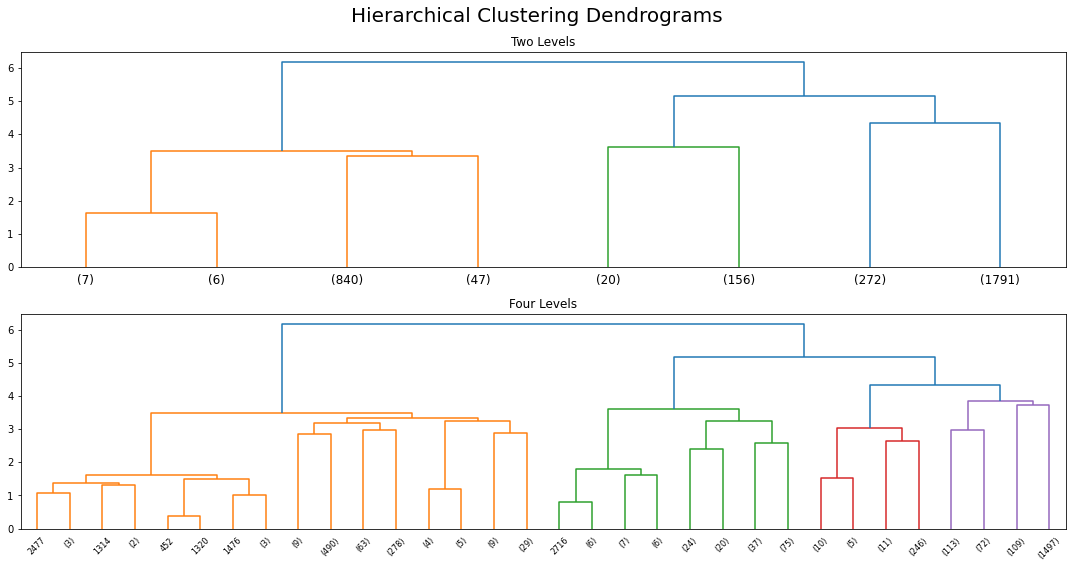

In [32]:
# plot the top 2 levels of the dendrogram
f, [ax1, ax2] = plt.subplots(2, 1, figsize = (15, 8))
f.suptitle('Hierarchical Clustering Dendrograms', fontsize = 20)
plot_dendrogram(hier_no_dist, truncate_mode="level", p=2, ax = ax1)
plot_dendrogram(hier_no_dist, truncate_mode="level", p=4, ax = ax2)
ax1.set_title('Two Levels')
ax2.set_title('Four Levels')
plt.tight_layout();

### Results 

The performance is less than that of K-Means, but the documents appear to be clustered well. Looking above, it looks like two main clusters exist, which likely correspond to the broad categories. Depending on the depth of the dendrogram plotted, you can see how subclusters are being formed within each main cluster. Each cluster is formed according to the height of the dendrogram (see y axis), cutting at different places produces different number of clusters. 

# 3. Going Further

As you've seen, with proper cleaning and careful choices of hyperparameters, you can cluster documents with clearly defined themes. One thing to note however is that each document belongs to a broad class of categories, but there are more specific categories within each of the broad ones. Algorithms exist (such as hierarchical clustering) which can effectively look for clusters within clusters. 

# 4. Excercises

1. Using the cleaned dataset, for each clustering algorithm, find the the top 10 occurring words in each cluster and how often they occur. Hint: the CountVectorizer object above can be used to do this. Only needs to be done for clustering of broad categories (e.g. computing, recreation). 


2. For each of the broad categories (computers, recreation), do the following:
    a. Determine finer categories within each (e.g. graphics, baseball, hockey, etc.). There's no right or wrong answer here. Use your imagination on this one! 
    b. Repeat one or both the clustering analyses, while doing the following:
        - Print off a cross tab table for each clustering
        - Print off the homogeneity score
        - Find the top 10 most frequently occuring words in each of these clusters
    
3. What are some other sources of real world texts that might be useful to cluster (either for yourself, a business, etc.)? Try to come up with at least 5.

4. Try testing different configurations and hyper-parameters for both clustering algorithms to try to maximize performance. Reference the documentation provided for each clustering algorithm, as well as this guide on clustering: [scikit-learn Clustering Guide](https://scikit-learn.org/stable/modules/clustering.html)